### Image Classification model from Keras

In this notebook, I go through the steps to create a Deel Learnin model from Keras, and then upload it to Hugging Face, so that I can use it at any time.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

import os

In [5]:
# Directory where the data is located
data_dir = r"C:\Users\alvar\Desktop\UCM-TFM-G1\data\waste-classifier\dataset-splits-custom\dataset_splits"
train = r"C:\Users\alvar\Desktop\UCM-TFM-G1\data\waste-classifier\dataset-splits-custom\dataset_splits\train"
val = r"C:\Users\alvar\Desktop\UCM-TFM-G1\data\waste-classifier\dataset-splits-custom\dataset_splits\test"
# Lists files and directories in the specified location
files_and_directories_train = os.listdir(train)
# Print files
print("Archivos y directorios en", train)
print(files_and_directories_train)

files_and_directories_test = os.listdir(val)
# Print files
print("Archivos y directorios en", val)
print(files_and_directories_test)

Archivos y directorios en C:\Users\alvar\Desktop\UCM-TFM-G1\data\waste-classifier\dataset-splits-custom\dataset_splits\train
['cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'trash']
Archivos y directorios en C:\Users\alvar\Desktop\UCM-TFM-G1\data\waste-classifier\dataset-splits-custom\dataset_splits\test
['cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [6]:
# Define the directory paths for train and validation datasets
train_dir = r"C:\Users\alvar\Desktop\UCM-TFM-G1\data\waste-classifier\dataset-splits-custom\dataset_splits\train"
val_dir = r"C:\Users\alvar\Desktop\UCM-TFM-G1\data\waste-classifier\dataset-splits-custom\dataset_splits\test"

# Define transforms for data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

# Create datasets using ImageFolder
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

# Create data loaders for train and validation datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# Print the class labels
print("Class labels:", train_dataset.classes)

# Print the number of samples in each dataset
print("Number of samples in train dataset:", len(train_dataset))
print("Number of samples in validation dataset:", len(val_dataset))


Class labels: ['cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'trash']
Number of samples in train dataset: 2092
Number of samples in validation dataset: 644


In [7]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.25),
    layers.RandomZoom(0.25),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(factor=0.3)
  ]
)

In [9]:
image_size = (224,224)
batch_size = 64

In [10]:
pretrained_model = tf.keras.applications.EfficientNetV2L(input_shape=image_size+(3,), include_top=False)
pretrained_model.trainable = False
pretrained_model.summary()

Model: "efficientnetv2-l"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['rescaling[0][0]']           
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 112, 112, 32)         128       ['stem_conv[0][0]']           
 n)                                                                                

In [11]:
preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input

In [12]:
inputs = tf.keras.Input(shape=image_size+(3, ), name='input')
data_aug = data_augmentation(inputs)
reescaling = preprocess_input(data_aug)

x = pretrained_model(reescaling, training=False)
x = tf.keras.layers.Flatten()(x)

x2 = layers.Dropout(0.5)(x)
x2 = layers.Dense(128, activation='relu')(x2)
# A Dense classifier with a single unit (binary classification
outputs = tf.keras.layers.Dense(12, activation='softmax')(x2)
model_tl = keras.Model(inputs, outputs)

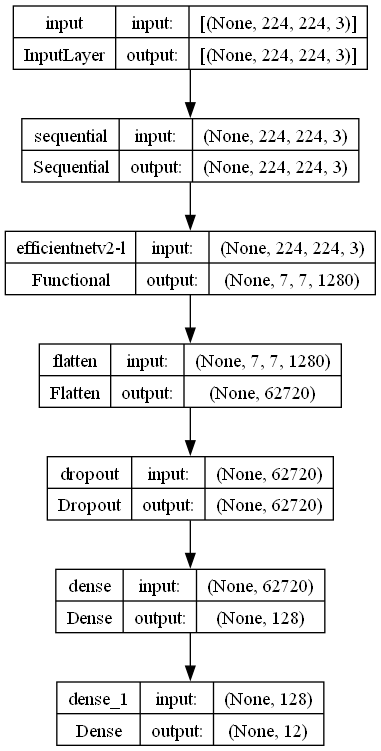

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(model_tl, show_shapes=True)

In [14]:
es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # can be 'val_accuracy'
    patience=5,  # if during 5 epochs there is no improvement in `val_loss`, the execution will stop
    verbose=1)

In [15]:
model_tl.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
epochs = 1
batch_size=10

In [16]:
# Convert PyTorch data loaders to NumPy arrays for Keras
train_images = []
train_labels = []
for images, labels in train_loader:
    train_images.append(images.numpy())
    train_labels.append(labels.numpy())

train_images = np.concatenate(train_images, axis=0)
train_labels = np.concatenate(train_labels, axis=0)

val_images = []
val_labels = []
for images, labels in val_loader:
    val_images.append(images.numpy())
    val_labels.append(labels.numpy())

val_images = np.concatenate(val_images, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

# Transpose dimensions for PyTorch data to match Keras/TensorFlow format
train_images = np.transpose(train_images, (0, 2, 3, 1))
val_images = np.transpose(val_images, (0, 2, 3, 1))

C:\Users\alvar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [17]:
# Now you can use train_images, train_labels, val_images, val_labels in the fit() method
history = model_tl.fit(train_images, train_labels,
                       validation_data=(val_images, val_labels),
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=1,
                       callbacks=[es_callback])

Epoch 1/2
210/210 [==============================] - 1014s 5s/step - loss: 6.8453 - accuracy: 0.1998 - val_loss: 4.0387 - val_accuracy: 0.2857
Epoch 2/2
210/210 [==============================] - 990s 5s/step - loss: 3.7246 - accuracy: 0.2213 - val_loss: 2.3012 - val_accuracy: 0.2516


In [18]:
from huggingface_hub import notebook_login

notebook_login()

In [21]:
model_tl.save('model1')

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


In [28]:
from huggingface_hub import from_pretrained_keras

model = from_pretrained_keras("ALVHB95/finalsupermodelofthedestiny")

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

keras_metadata.pb:   0%|          | 0.00/3.34M [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

saved_model.pb:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

history.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

variables.data-00000-of-00001:   0%|          | 0.00/568M [00:00<?, ?B/s]

variables/variables.index:   0%|          | 0.00/78.3k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/739 [00:00<?, ?B/s]